In [ ]:
# !pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# !pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

^C


### downloading the model weights

In [2]:
import os
HOME = os.getcwd()

In [3]:
print(HOME)

/Users/vivek/work/GIT/AI-Visual-Placement


In [ ]:
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
# !pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# !mkdir -p {HOME}/data

# !wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
# !wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
# !wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
# !wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 998.2 kB/s eta 0:00:00m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 MB 705.9 kB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 329.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.0 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 981.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 675.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 897.9 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## loading the model

In [4]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint="weights/sam_vit_h_4b8939.pth.1").to(device=DEVICE)

### importing the mask generator


In [7]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [27]:
import os

IMAGE_NAME = "dataset/LivingRoom1.jpeg"
# IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

## generating the mask with sam

In [45]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_NAME)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [46]:
len(sam_result)

73

In [47]:
sam_result[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

### display mask with specific index

In [49]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

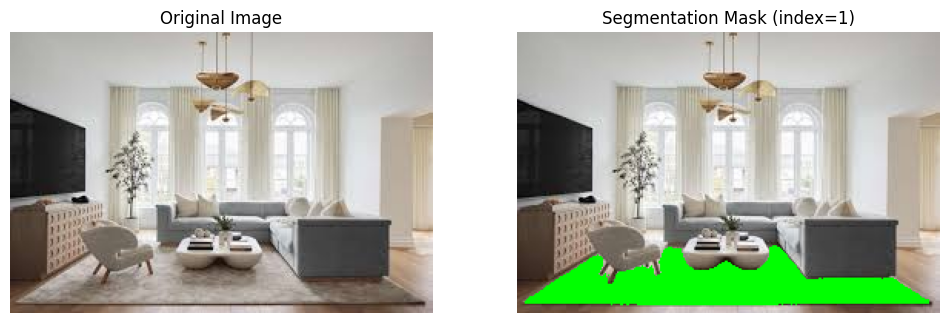

In [52]:
# Show original image and segmentation mask for a user-selected index

import matplotlib.pyplot as plt

# Ask user for the mask index
carpet_index = 1

# Get the mask for the selected index
carpet_mask = masks[carpet_index]

# Create an overlay of the mask on the original image
overlay = image_bgr.copy()
overlay[carpet_mask.astype(bool)] = [0, 255, 0]  # Green overlay for mask

# Plot original and segmented images side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Segmentation Mask (index={carpet_index})")
plt.axis('off')

plt.show()

## perform overlay

# TRASH CODE TRASH CODE TRASH CODE TRASH CODE TRASH CODE TRASH CODE

In [31]:
# from segment_anything import SamPredictor, sam_model_registry
# import cv2
# import numpy as np
# # Load image
# image = cv2.imread("dataset/DiningRoom1.jpeg")
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Initialize predictor
# sam = sam_model_registry["vit_h"](checkpoint="weights/sam_vit_h_4b8939.pth.1")
# predictor = SamPredictor(sam)

# predictor.set_image(image_rgb)

# # Provide a point prompt roughly on the carpet area
# input_point = np.array([[400, 500]])  # (x,y) coordinate on carpet
# input_label = np.array([1])  # 1 = foreground

# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=True
# )

# # Choose the best mask (highest score)
# mask = masks[scores.argmax()]

### understanding the result

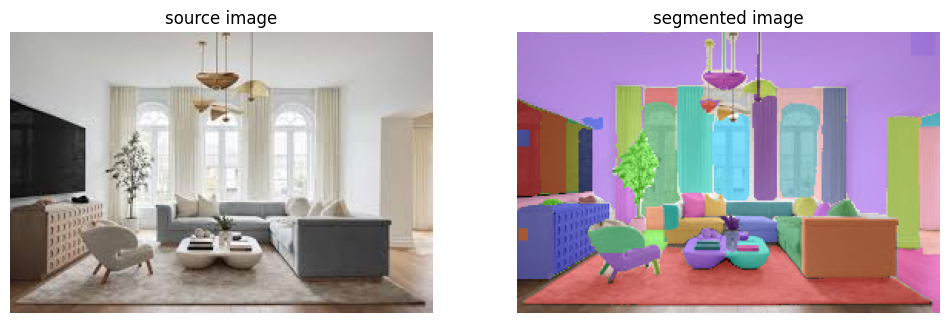

In [32]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### analysing the binary mask

In [33]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

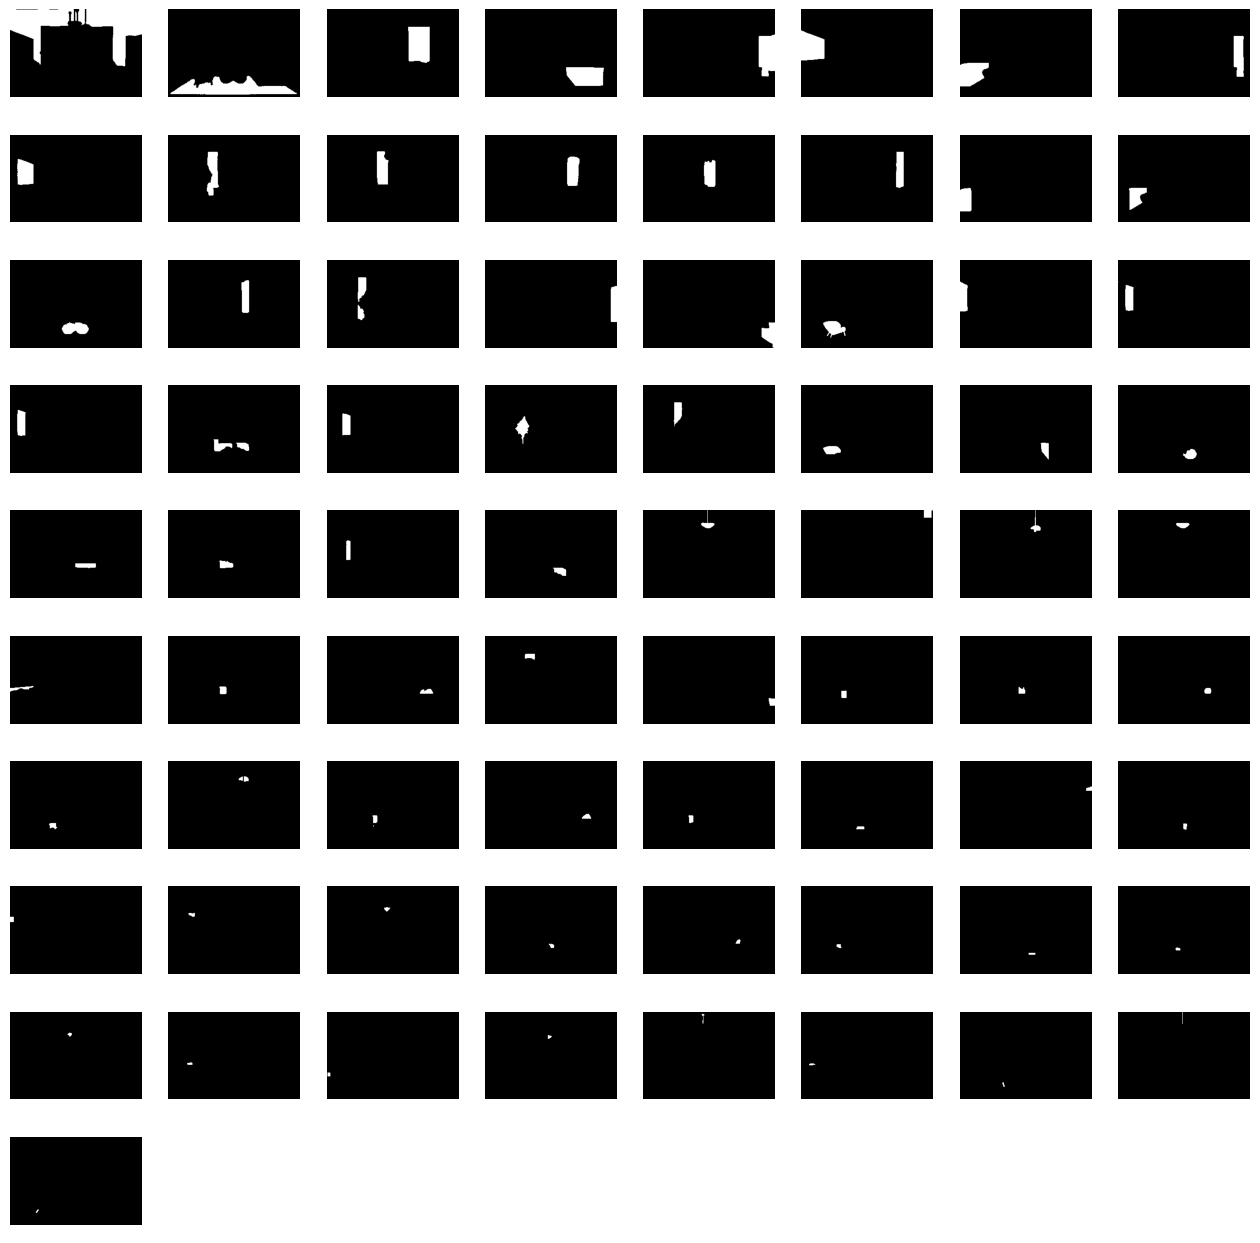

In [34]:
import math

ncols = 8
nrows = math.ceil(len(masks) / ncols)

sv.plot_images_grid(
    images=masks,
    grid_size=(nrows, ncols),
    size=(16, 16)
)

### segmetation with bounding box

In [35]:
mask_predictor = SamPredictor(sam)

import os


IMAGE_PATH = "dataset/LivingRoom1.jpeg"

#### drawing the box

In [36]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [37]:
IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [38]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [39]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [40]:
import numpy as np

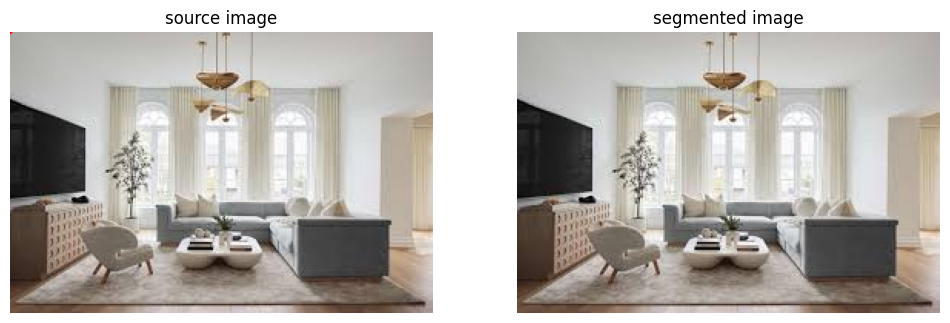

In [41]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

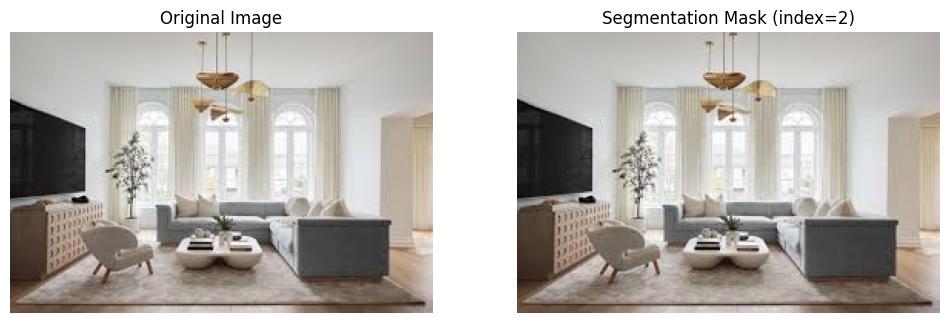

In [44]:
# Show original image and segmentation mask for a user-selected index

import matplotlib.pyplot as plt

# Ask user for the mask index
carpet_index = 2

# Get the mask for the selected index
carpet_mask = masks[carpet_index]

# Create an overlay of the mask on the original image
overlay = image_bgr.copy()
overlay[carpet_mask.astype(bool)] = [0, 255, 0]  # Green overlay for mask

# Plot original and segmented images side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Segmentation Mask (index={carpet_index})")
plt.axis('off')

plt.show()